# NOTE: This Kernel is not finished. I'm working on it yet. 
Votes up the kernel and stay tuned.


# Introduction

In this notebook I will create a baseline to understand the Jigsaw data and after it create my model to predict Toxic Comments.

## Competition Description:
Can you help detect toxic comments ― and minimize unintended model bias? That's your challenge in this competition.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

Last year, in the Toxic Comment Classification Challenge, you built multi-headed models to recognize toxicity and several subtypes of toxicity. This year's competition is a related challenge: building toxicity models that operate fairly across a diverse range of conversations.

Here’s the background: When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

In this competition, you're challenged to build a model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. You'll be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias. Develop strategies to reduce unintended bias in machine learning models, and you'll help the Conversation AI team, and the entire industry, build models that work well for a wide range of conversations.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.



## Some questions that I will try to answer: <br>
- What is the distribuition of Toxicity?<br>
- What is the most attacked group?<br>
- We can see some difference between comments of toxic and non-toxic comments?<br>
- Are the date of the year correlated with the toxicity comments?<br>
- The toxicity ratio is equal to all articles?<br>
- What's the groups with the highest toxicity, likes, disagrees.  
- And much more.


English is not my first language, so sorry for any mistake. 

# Let's start the work

## Import librarys

In [1]:
# Basic Pydata Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt     
import seaborn as sns

# Standard plotly imports
import plotly.offline as py 
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
from wordcloud import WordCloud, STOPWORDS

## warnings
import warnings
warnings.filterwarnings("ignore")

## Importing the Data

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

## Exploring some information about the data
- nulls
- data types
- shape
- First rows of dataset

In [3]:
# Missing values
df_train.isnull().sum() / len(df_train) * 100

id                                      0.000000
target                                  0.000000
comment_text                            0.000000
severe_toxicity                         0.000000
obscene                                 0.000000
identity_attack                         0.000000
insult                                  0.000000
threat                                  0.000000
asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino              

## Data info

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

## Shape of our data

In [5]:
df_train.shape

(1804874, 45)

## Head - knowning the data

In [6]:
df_train.head()

id            ...             toxicity_annotator_count
0  59848            ...                                    4
1  59849            ...                                    4
2  59852            ...                                    4
3  59855            ...                                    4
4  59856            ...                                   47

[5 rows x 45 columns]

Ok, Now that we have some idea of how the dataset is, we can start exploring and understanding the dataset

## Ploting Target (Toxicity) distribuition

Total of zero values in Toxic rate: 70.07%


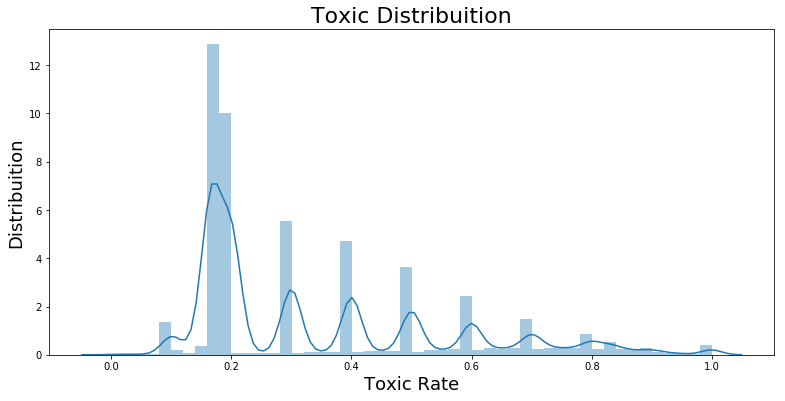

In [7]:
count_target_zero = round(df_train[df_train['target'] == 0]['target'].count() / len(df_train['target']) * 100,2)
print(f'Total of zero values in Toxic rate: {count_target_zero}%')

plt.figure(figsize=(13,6))

g = sns.distplot(df_train[df_train['target'] > 0]['target'])
plt.title('Toxic Distribuition', fontsize=22)
plt.xlabel("Toxic Rate", fontsize=18)
plt.ylabel("Distribuition", fontsize=18) 

plt.show()

Interesting distribuition. <br>
For default, in the competition description we will consider toxic when the target has values above 0.5

## Toxicity Subtype attributes Distribution

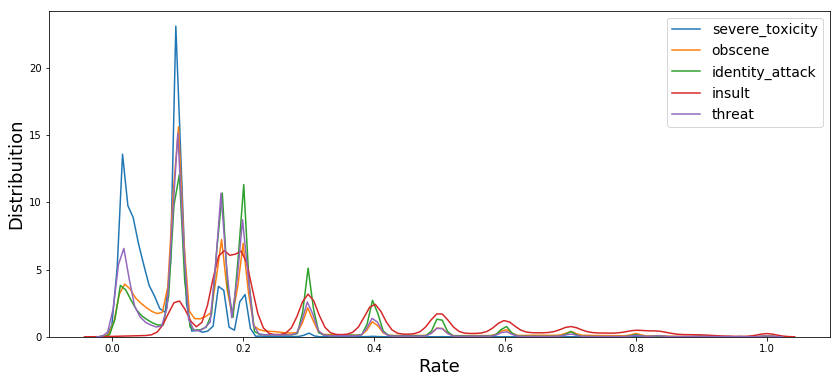

In [8]:
comment_adj = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

plt.figure(figsize=(14,6))

for col in comment_adj[1:]:
    g = sns.distplot(df_train[df_train[col] > 0][col], label=col, hist=False)
    #plt.legend(f'{col} Distribuition', fontsize=22)
    plt.xlabel("Rate", fontsize=18)
    plt.ylabel("Distribuition", fontsize=18)
    plt.legend(loc=1, prop={'size': 14})

plt.show()

## Creating a flag to separe Toxic and Non-Toxic comments (Target >= 0.5)

In [9]:
## Creating a flag to toxic and non-toxic comments
df_train['toxic'] = np.where(df_train['target'] >= .5, 'Toxic', 'Non-Toxic')

## Ploting the Distribuition of Categorical Toxic and Non-Toxic

In [10]:
df_train['toxic'].value_counts().iplot(kind='bar', xTitle='Toxic or Non-Toxic', yTitle="Count", 
                                       title='Distribuition of Toxicity of comments')

## Defining some categories of comment and counting

In [11]:
etnics = ['asian' , 'latino' , 'black', 'white', 'other_race_or_ethnicity']

religions = ['atheist', 'buddhist', 'hindu', 'jewish', 'muslim', 'christian', 'other_religion']

sexual = ['female', 'male', 'other_gender'] 

sexual_orientation = ['heterosexual', 'bisexual', 'transgender', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']

disabilities = ['intellectual_or_learning_disability', 'physical_disability', 'psychiatric_or_mental_illness', 'other_disability']

reactions = ['funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit']

## Grouping by toxic by each demographic 

In [12]:
## The inspiration to this kernel is https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

etnics_dem = df_train.loc[:, ['target']+list(etnics + ['toxic'])].dropna()
count_etnics = etnics_dem.iloc[:, 1:][etnics_dem.iloc[:, 1:] > 0].groupby('toxic').count()

religion_dem = df_train.loc[:, ['target']+list(religions  + ['toxic'])].dropna()
count_religions = religion_dem.iloc[:, 1:][religion_dem.iloc[:, 1:] > 0].groupby('toxic').count()

sexual_dem = df_train.loc[:, ['target']+list(sexual  + ['toxic'])].dropna()
count_sexual = sexual_dem.iloc[:, 1:][sexual_dem.iloc[:, 1:] > 0].groupby('toxic').count()

sexual_orient = df_train.loc[:, ['target']+list(sexual_orientation  + ['toxic'])].dropna()
count_orient_sexual = sexual_orient.iloc[:, 1:][sexual_orient.iloc[:, 1:] > 0].groupby('toxic').count()

disabilities_dem = df_train.loc[:, ['target']+list(disabilities  + ['toxic'])].dropna()
count_desabilities = disabilities_dem.iloc[:, 1:][disabilities_dem.iloc[:, 1:] > 0].groupby('toxic').count()

## Creating a list to plot

In [13]:
list_groupbys = [count_etnics, count_religions, count_sexual, count_orient_sexual, count_desabilities]
list_names = ['Ethnics Comments by Toxic and Non-Toxic Classification',
              'Religions Comments by Toxic and Non-Toxic Classification',
              'Sexual Comments by Toxic and Non-Toxic Classification',
              'Sexual Orientation Comments by Toxic and Non-Toxic Classification',
              'Disabilities Comments by Toxic and Non-Toxic Classification', ]

## Ploting the distribuitions of the data modelling

In [14]:
for plot, text in zip(list_groupbys, list_names):
    plot.T.iplot(kind='bar', xTitle='Demographic categories', yTitle='Count',
                 title=text)

We can see and have insight about some of the toxicy comments. Further, I will explore the comments;

## Rating distribution

In [15]:
df_train['rating'].value_counts().iplot(kind='bar', title='Rating of Comment', 
                                        xTitle='Rating', yTitle='Count')

## Rating by Toxic and Non-Toxic comments

In [16]:
round((pd.crosstab(df_train['rating'], df_train['toxic'], 
            normalize='index') * 100),2).iplot(kind='bar', barmode='stack', 
                                               title= "Rating Ratio by Toxic and Non-Toxic",
                                               xTitle="Rating Status", yTitle='% of Toxic and Non-Toxic')


It's interesting. <br>
5% of approved comments are Toxic; <br>
As we can see 66% of rejected comments aren't toxic.


## Understanding Toxic and Non-Toxic Comments by Dates

In [17]:
# transforming to pandas 
df_train['created_date'] = pd.to_datetime(df_train['created_date'], format='%Y-%m-%d %H:%M:%S')

df_train['month'] = df_train['created_date'].dt.month
df_train['weekday'] =  df_train['created_date'].dt.weekday_name
df_train['hour'] =  df_train['created_date'].dt.hour

# df_train['created_date'] = pd.to_datetime(df_train['created_date'])

In [18]:
# printing the first and last date
print(f'The first date is {df_train["created_date"].dt.date.min()} and the last date is {df_train["created_date"].dt.date.max()}')

The first date is 2015-09-29 and the last date is 2017-11-11


In [19]:
# I will filter by comments date higher than 2016-01-01
toxic_comment_dates = df_train[df_train['created_date'] >= '2016-01-01'].groupby([df_train['created_date'].dt.date,'toxic'])['id'].count().sort_index().unstack("toxic").fillna(0)

toxic_comment_dates.iplot(kind='bar', barmode='stack', 
                   title='Toxic and Non-Toxic Comment by Date', 
                   xTitle='Dates', yTitle='Comment Counts'
                )

We can see that altough the number comments has increased a lot, the toxic comments are seemgly a constant value

## Looking the distribution by Months;
We will consider the dates higher than 2016-01-01 so I have a small sample of months. <br>
It's just to explore and may find a interesting pattern.

In [20]:
# dates higher than 2016-01-01
toxic_comment_months = df_train[df_train['created_date'] >= '2016-01-01'].groupby(['month','toxic'])['id'].count().sort_index().unstack("toxic").fillna(0)

toxic_comment_months.iplot(kind='bar', barmode='group', 
                   title='Toxic and Non-Toxic Comment by Date', 
                   xTitle='Dates', yTitle='Comment Counts'
                )

## Looking the distribution by week days;

In [21]:
# dates higher than 2016-01-01
toxic_comment_week = df_train[df_train['created_date'] >= '2016-01-01'].groupby(['weekday','toxic'])['id'].count().sort_index().unstack("toxic").fillna(0).sort_index()

toxic_comment_week.iplot(kind='bar', barmode='group', 
                   title='Toxic and Non-Toxic Comment by Weekdays', 
                   xTitle='Weekday Names', yTitle='Comment Counts'
                )

In [22]:
# dates higher than 2016-01-01
toxic_comment_hour = df_train[df_train['created_date'] >= '2016-01-01'].groupby(['hour','toxic'])['id'].count().sort_index().unstack("toxic").fillna(0)

toxic_comment_hour.iplot(kind='bar', barmode='group', 
                   title='Toxic and Non-Toxic Comment by Hours', 
                   xTitle='Weekday Names', yTitle='Comment Counts'
                )

Very interesting distribuitions. <br>
also, we can see that the Toxicity ratio is very constant.

## Creating some features from comments 

In [23]:
#Setting the stopwords
eng_stopwords = set(stopwords.words("english"))

#Word count in each comment:
df_train['count_word']= df_train["comment_text"].apply(lambda x: len(str(x).split()))

#Unique word count
df_train['count_unique_word']=df_train["comment_text"].apply(lambda x: len(set(str(x).split())))

#Letter count
df_train['count_letters']=df_train["comment_text"].apply(lambda x: len(str(x)))

#punctuation count
df_train["count_punctuations"] = df_train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df_train["count_words_upper"] = df_train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
df_train["count_words_title"] = df_train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
df_train["count_stopwords"] = df_train["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
df_train["mean_word_len"] = df_train["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

## Distribuitions of the new features

In [24]:
comments_counts = ['count_word', 'count_unique_word', 'count_letters', 'count_punctuations', 
                   'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len']
def quantiles(columns):
    # To append the quantile outputs
    quantile_data = []

    # Looping for the created columns
    for counts in columns:
        # Quantiles from desired columns
        quantiles = df_train[counts].quantile([.01,.25,.5,.75,.99])
        # Store quantile DataFrame in list
        quantile_data.append(quantiles)

    # Now concat the data that you got the quantiles
    return pd.concat(quantile_data, axis=1)

In [25]:
quantiles(comments_counts)

count_word      ...        mean_word_len
0.01         2.0      ...             3.428571
0.25        16.0      ...             4.379310
0.50        35.0      ...             4.714286
0.75        72.0      ...             5.096774
0.99       178.0      ...             9.129411

[5 rows x 8 columns]

## Ploting distribuition of text metrics

In [26]:
trace0 = go.Box(
    x=df_train['toxic'].sample(20000),
    y=df_train['count_word'].sample(20000),
    name='Toxic', showlegend=False, jitter=0.2, marker = dict( color = 'rgb(0, 128, 128)')
)

trace2 = go.Box(
    x=df_train[(df_train['count_unique_word'] <= 128)]['toxic'].sample(20000),
    y=df_train[(df_train['count_unique_word'] <= 128)]['count_unique_word'].sample(20000),
    name='Toxic', showlegend=False, marker = dict( color = 'rgb(0, 128, 128)')
)

trace4 = go.Box(
    x=df_train[ (df_train['count_letters'] <= 999)]['toxic'].sample(20000),
    y=df_train[  (df_train['count_letters'] <= 999)]['count_letters'].sample(20000),
    name='Toxic',  showlegend=False, marker = dict( color = 'rgb(0, 128, 128)')
)


trace6 = go.Box(
    x=df_train[ (df_train['count_punctuations'] <= 45)]['toxic'].sample(20000),
    y=df_train[  (df_train['count_punctuations'] <= 45)]['count_punctuations'].sample(20000),
    name='Toxic',  showlegend=False, marker = dict( color = 'rgb(0, 128, 128)')
)


trace8 = go.Box(
    x=df_train[ (df_train['count_words_upper'] <= 9)]['toxic'].sample(20000),
    y=df_train[ (df_train['count_words_upper'] <= 9)]['count_words_upper'].sample(20000),
    name='Toxic', showlegend=False, marker = dict( color = 'rgb(0, 128, 128)')
)

trace10 = go.Box(
    x=df_train[ (df_train['count_words_title'] <= 9)]['toxic'].sample(20000),
    y=df_train[ (df_train['count_words_title'] <= 9)]['count_words_title'].sample(20000),
    name='Toxic', showlegend=False, marker = dict( color = 'rgb(0, 128, 128)')
)

trace12 = go.Box(
    x=df_train[ (df_train['count_stopwords'] <= 88)]['toxic'].sample(20000),
    y=df_train[ (df_train['count_stopwords'] <= 88)]['count_stopwords'].sample(20000),
    name='Toxic',  showlegend=False, marker = dict( color = 'rgb(0, 128, 128)')
)

trace14 = go.Box(
    x=df_train[  (df_train['mean_word_len'] <= 9.129411)]['toxic'].sample(20000),
    y=df_train[ (df_train['mean_word_len'] <= 9.129411)]['mean_word_len'].sample(20000),
    name='Toxic',  showlegend=False, marker = dict( color = 'rgb(0, 128, 128)')
    
)


data = [trace0, trace2, trace4, trace6,trace8, 
        trace10,trace12, trace14]

fig = tls.make_subplots(rows=4, cols=2, specs=[[{}, {}], 
                                               [{}, {}], 
                                               [{}, {}], 
                                               [{}, {}]],
                          subplot_titles=('Word Counts','Unique Words Count', 'Letters Count', 'Punctuation Count', 
                                          'Upper Case Count','Words Title Count', 'Stopwords Count', 'Mean Words Len'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace6, 2, 2)
fig.append_trace(trace8, 3, 1)
fig.append_trace(trace10, 3, 2)
fig.append_trace(trace12, 4, 1)
fig.append_trace(trace14, 4, 2)

fig['layout'].update(title='Comment Metrics by Toxic and Non-Toxic', autosize=True, boxmode='group')

iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]
[ (4,1) x7,y7 ]  [ (4,2) x8,y8 ]



## HELP: How can I set manually the size of box?! 
Why they're not not aligned?

In [27]:
#testing a violin plot

# Finding the highest values for each demographic group

In [28]:
df_train['attacked_group'] = df_train[etnics+ sexual + sexual_orientation + religions + disabilities].replace(0, np.nan).idxmax(axis=1)
df_train['attacked_group'] = df_train['attacked_group'].fillna("No demo group detected")

In [29]:
att_count = df_train['attacked_group'].value_counts()
print(f"Total of No Demographic Group Detected {att_count[0]}")

df_train[df_train['attacked_group'] != 'No demo group detected']['attacked_group'].value_counts().iplot(kind='bar', title='Count of Highest values in Attacked Groups',
                                                xTitle='Demographic Group Name', yTitle='Count of highest "Citations"')

Total of No Demographic Group Detected 1578640


We have almost 1.6M comments that are not related to demographic groups that are in the categories

## Looking the % ratio of Toxic and Non-Toxic for each demo group

In [30]:
attacked_group = pd.crosstab(df_train['attacked_group'],df_train['toxic'], aggfunc='count', values=df_train['target']).apply(lambda r: r/r.sum(), axis=1)
attacked_group.iplot(kind='bar',barmode='stack',
                     title='Percent of Toxic and Non-Toxic Comments for Attacked Groups',
                     xTitle='Demographic Group Name', yTitle='Percent ratio of each Group')

It's a very informative visualization. <br>We can see that some categories, as blacks, hindu (indians?), and hetero(??) orientation  has a highest number of toxic comments against this group. 

## Understanding the "Reaction" metrics

In [31]:
## Again, calling the quantile function that we created before
quantiles(reactions)


aggs = {
    'sexual_explicit': ['sum', 'size'],
    'likes': ['sum'],
}

# Previous applications categorical features

prev_agg = df_train[df_train['attacked_group'] != 'No demo group detected'].groupby(['attacked_group','toxic']).agg({**aggs})

prev_agg.columns = pd.Index(['Agg_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

prev_agg.rename(columns={'Agg_sexual_explicit_SUM':'Sexual bias sum',
                         'Agg_likes_SUM':' Likes sum',
                         'Agg_sexual_explicit_SIZE':'Total Comments'}, inplace=True)
prev_agg.T

attacked_group          asian      ...              white
toxic               Non-Toxic      ...              Toxic
Sexual bias sum     19.035963      ...         118.427429
Total Comments    6875.000000      ...        5199.000000
 Likes sum       16669.000000      ...       13320.000000

[3 rows x 48 columns]

In [32]:
prev_agg.sort_index().unstack("toxic").fillna(0).iplot(kind='bar', showlegend=False, 
                                                       title ='Demographic Groups by Sum of sexual explicit and Sum of Likes',
                                                       xTitle='Demographic Groups', yTitle='Count')

- I will try a way to best apresent this chart above

It's another interesting information about the data. Below, I will try to investigate it further;

## Let's invetigate some "stealth" columns by many metrics
- Some tests using PieChart

In [33]:
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

def PieChart(df_cat, df_value, title, limit=15):
    """
    This function helps to investigate the proportion of metrics of toxicity and other values
    """

    # count_trace = df_train[df_cat].value_counts()[:limit].to_frame().reset_index()
    rev_trace = df_train[df_train['toxic'] == "Toxic"].sample(50000).groupby(df_cat)[df_value].mean().nlargest(limit).to_frame().reset_index()
    rev_trace_non = df_train[df_train['toxic'] != "Toxic"].sample(50000).groupby(df_cat)[df_value].mean().nlargest(limit).to_frame().reset_index()

    trace1 = go.Pie(labels=rev_trace_non[df_cat], 
                    values=rev_trace_non[df_value], name= "Non-Toxic", hole= .5, 
                    hoverinfo="label+percent+name+value", showlegend=True,
                    domain= {'x': [0, .48]})

    trace2 = go.Pie(labels=rev_trace[df_cat], 
                    values=rev_trace[df_value], name="Toxic", hole= .5, 
                    hoverinfo="label+percent+name+value", showlegend=False, 
                    domain= {'x': [.52, 1]})

    layout = dict(title= title, height=450, font=dict(size=15),
                  annotations = [
                      dict(
                          x=.20, y=.5,
                          text='Non-Toxic', 
                          showarrow=False,
                          font=dict(size=20)
                      ),
                      dict(
                          x=.80, y=.5,
                          text='Toxic', 
                          showarrow=False,
                          font=dict(size=20)
                      )
        ])

    fig = dict(data=[trace1, trace2], layout=layout)
    iplot(fig)

## Sexual Explicit by Attacked Groups

In [34]:
PieChart("attacked_group", 'sexual_explicit', "Mean of sexual Explicit by categories", limit=10)

Wow. It's very interesting and curious. <br>
In Non-Toxic:<br>
As we can see, comments about Transgender has a value 3 times highest than the third position. <br>
  
In Toxic:<br>
It's interesting that atheists has a very high mean in sexual explicit. I will investigate this category further in comments.

## Likes by Attacked Group

In [35]:
PieChart("attacked_group", 'likes', "Mean of sexual Explicit by categories", limit=10)

## Likes distribution by Articles Id

In [36]:
PieChart("article_id", 'likes', "Mean Likes in Toxic and Non-Toxic comments by TOP 10 Articles", limit = 10)

## Sexual Explicit distribution by Articles Id

In [37]:
PieChart("article_id", 'sexual_explicit', "Mean Sexual Explicit in Comments by TOP 10 Articles", limit = 10)

## Toxicity mean by Publication

In [38]:
PieChart("publication_id", 'target', "Mean Target (Toxicity) in Comments by each Publication", limit = 10) 

## Sexual Explicit by Publication Id

In [39]:
PieChart("publication_id", 'sexual_explicit', "Mean Sexual Explicit in comments by Publication", limit = 10)

## Likes distribution by Publication Id

In [40]:
PieChart("publication_id", 'likes', "Mean Likes in Comments by each Publication", limit = 10)

As we can see, the unique valid values are likes and sexual explicit. <br>
Let's investigate it further

## Knowing identity_annotator_count

In [41]:
name = df_train['identity_annotator_count'].value_counts()[:8]

fig = pd.crosstab(df_train[df_train['identity_annotator_count'].isin(name.index)]['identity_annotator_count'], 
                  df_train[df_train['identity_annotator_count'].isin(name.index)]['toxic'], 
                  normalize='index').iplot(kind='bar', barmode='stack', bargap=.2, asFigure=True,
                                           title= "TOP 8 Identity Annotator by Toxic and Non-Toxic",
                                           xTitle="Identity Annotator Count", yTitle='Count')
fig.layout.xaxis.type = 'category'
iplot(fig)

99% of all data are in this top 8 Identitity annotators. <br>
The value of toxic on the value 0 is lowest in proportionality than Identity Annotator 4;<br>
What it means? 

## WordCloud of Non-Toxic Comments

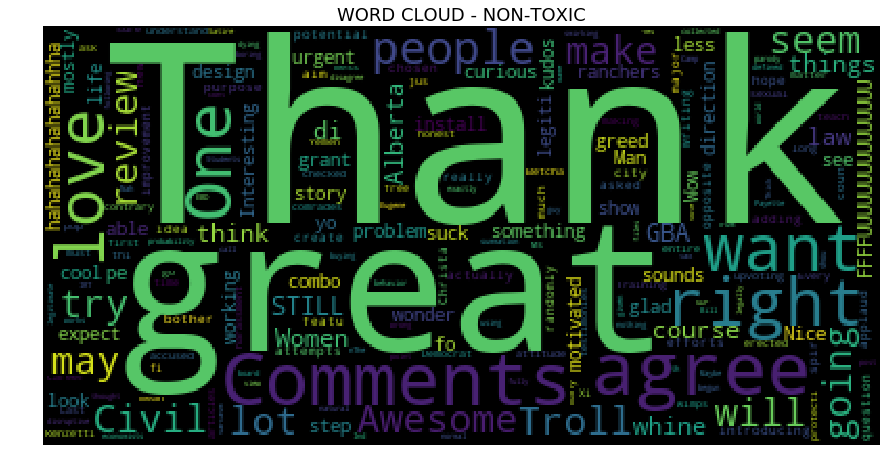

In [42]:

text_to_analize= df_train[df_train['toxic'] == "Non-Toxic"]['comment_text']

plt.rcParams['font.size']= 15              
plt.rcParams['savefig.dpi']= 100         
plt.rcParams['figure.subplot.bottom']= .1 

plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(text_to_analize))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - NON-TOXIC")
plt.axis('off')
plt.show()

## WordCloud of Toxic Comments

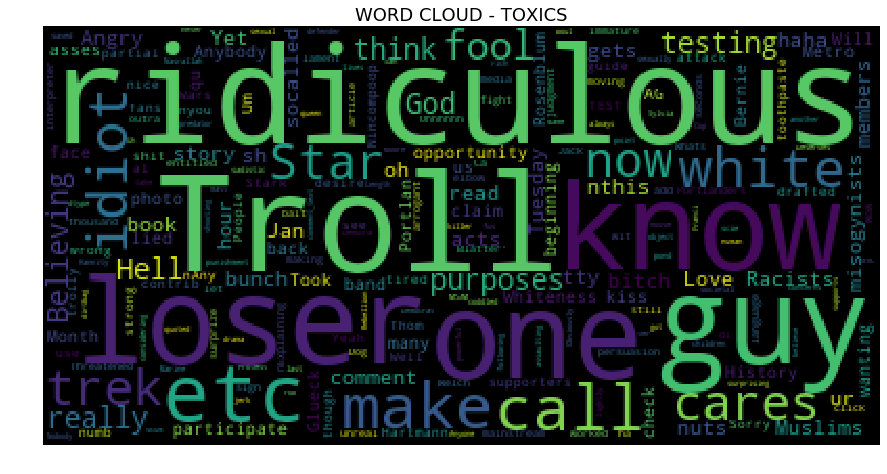

In [43]:
from wordcloud import WordCloud, STOPWORDS

text_to_analize= df_train[df_train['toxic'] == "Toxic"]['comment_text']
plt.rcParams['font.size']= 15              
plt.rcParams['savefig.dpi']= 100         
plt.rcParams['figure.subplot.bottom']= .1 

plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(text_to_analize))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - TOXICS")
plt.axis('off')
plt.show()

## I will keep improving and Working on this Kernel. 
# If you liked this Kernel, please votes up the kernel 

Some fonts that I used to inspire and learn to build this kernel: <br>
https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw <br>
https://www.kaggle.com/gpreda/jigsaw-eda <br>
and a lot of other that I forget to save the link